In [1]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np

from keras import backend as K
from keras.models import Model
from keras.applications import vgg19

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

Using TensorFlow backend.


In [2]:
def preprocess_image(image_path,height,width):
    height = height
    width = width 
    img = Image.open(image_path)
    img = img.resize((width, height))
    img = np.asarray(img, dtype='float32')
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(img):
    img[:,:,:,0] -= 103.939
    img[:,:,:,1] -= 116.779
    img[:,:,:,2] -= 123.68
    img = img[:, :, :, ::-1]
    return img

In [3]:
img_height = 512
img_width = 512
content_path = 'C:\\Users\\dell\\Desktop\\child.png'
style_path = 'C:\\Users\\dell\\Desktop\\water.png'

content_array = preprocess_image(content_path, img_height, img_width)
print(content_array.shape)
content_image = K.variable(deprocess_image(content_array))
style_array = preprocess_image(style_path, img_height, img_width)
print(content_array.shape)
style_image = K.variable(deprocess_image(style_array))

combination_image = K.placeholder((1, img_height, img_width, 3))
input_tensor = K.concatenate([content_image,style_image,combination_image],axis=0)

(1, 512, 512, 3)
(1, 512, 512, 3)


In [4]:
model = vgg19.VGG19(input_tensor = input_tensor, weights = 'imagenet', include_top = False)
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv4': <tf.Tensor 'block3_conv4/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 

In [5]:
def content_loss(content,combination):
    return  K.sum(K.square(combination-content))

def style_loss(style,combination,height,width):
    def build_gram_matrix(x):
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
        gram_matrix = K.dot(features, K.transpose(features))
        return gram_matrix
    
    S = build_gram_matrix(style)
    C = build_gram_matrix(combination)
    channels = 3
    size = height * width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

def total_variation_loss(x):
    a = K.square(x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [6]:
content_weight = 0.025
style_weight = 1.0
total_variation_weight = 1e-4
loss = K.variable(0.)

content_layer = 'block5_conv2'
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 
                'block4_conv1', 'block5_conv1']

layer_features = layers[content_layer]
content_features = layer_features[0,:,:,:]
combination_features = layer_features[2,:,:,:]
loss += content_weight * content_loss(content_features,combination_features)

for layer_name in style_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1,:,:,:]
    combination_features = layer_features[2,:,:,:]
    sl = style_loss(style_features, combination_features,img_height,img_width)
    loss += (style_weight / len(style_layers)) * sl
    
loss += total_variation_weight * total_variation_loss(combination_image)

In [7]:
grads = K.gradients(loss, combination_image)[0]
fetch_loss_and_grads = K.function([combination_image],[loss,grads])

def eval_loss_and_grads(x, height, width):
    x = x.reshape((1,height, width, 3))
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self,height=None, width=None):
        self.loss_value = None
        self.grads_values = None
        self.height = height
        self.width = width

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x,self.height,self.width)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator(img_height,img_width)

In [8]:
iterations = 20
x = preprocess_image(content_path, img_height, img_width)
x = x.flatten()

for i in range(iterations):
    print('Start of iteration', i+1)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i+1, end_time - start_time))

Start of iteration 1
Current loss value: 8288205000.0
Iteration 1 completed in 647s
Start of iteration 2
Current loss value: 3709110300.0
Iteration 2 completed in 664s
Start of iteration 3
Current loss value: 2461308000.0
Iteration 3 completed in 2002s
Start of iteration 4
Current loss value: 1904592600.0
Iteration 4 completed in 627s
Start of iteration 5
Current loss value: 1525983700.0
Iteration 5 completed in 644s
Start of iteration 6
Current loss value: 1327940200.0
Iteration 6 completed in 659s
Start of iteration 7
Current loss value: 1192827800.0
Iteration 7 completed in 2807s
Start of iteration 8
Current loss value: 1061540700.0
Iteration 8 completed in 650s
Start of iteration 9
Current loss value: 966537900.0
Iteration 9 completed in 726s
Start of iteration 10
Current loss value: 889891140.0
Iteration 10 completed in 723s
Start of iteration 11
Current loss value: 831511000.0
Iteration 11 completed in 681s
Start of iteration 12
Current loss value: 770006700.0
Iteration 12 comple

In [9]:
x = x.reshape((img_height, img_width, 3))
x = x[:, :, ::-1]

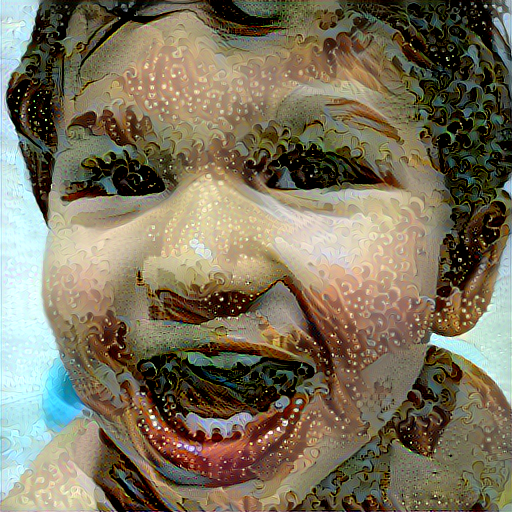

In [10]:
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)